In [1]:
"""
This is a machine learning script developed to create a model to predict "Tg Response".
    workflow:
        1. Read the excel sheet and create a dataframe.
        2. Using biopython module check if the corresponding sequences (last 7 residues) are similar to UniProt enteries given in excel sheet.
        3. Train and test the RNN model using 10:1 ratio of the data given
        4. Prediction of new sequences and their "Tg Response" values based on the model

Input files:
    Input file is an excel sheet.
    "SERCaMP Library Gene List with mass spec.xlsx" in present case

Important:
    Machine learning is stochastic in nature which means that the predictions will differ from run to run.  


Written by:
    Min Xu
    
Documentation by:
    Ravi Kumar Verma
    

module needed.

    tensorflow: TensorFlow is an open source software library for high performance numerical computation.
        you need to load tensorflow prior to use this code.
        see README file

    r2_score: is a regression scoring function implemented in sklearn
        Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
        A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

    BioPython
        biowulf doesnot have biopython and xlrd libraries installed, so cells using these functions can not be used.
        prepare and save dataframe input on your machine and then run the rest of the code on Biowulf.
"""

import pandas as pd

import numpy as np
import tensorflow as tf

from Bio import SeqIO
import requests
from io import StringIO

from sklearn.metrics import r2_score

import pprint

%matplotlib inline
import matplotlib.pyplot as plt

Processing the data
---------

In [2]:
"""

read the excel file provided and store the information in a dataframe.

"""


df = pd.read_excel('SERCaMP_Library_Gene_List_with_mass_spec.xlsx', header = 1, parse_cols='B:Q')

df = df.dropna(axis = 0, how = 'all')

s = pd.Series([''.join(df.iloc[i, 4:11]) for i in range(df.shape[0])])
df['tail'] = s.values

n_pos = np.where(df.index.values == 'SERCaMP (+)')[0][0] 
label = [0] * n_pos + [1] * (df.shape[0] - n_pos)
df['Label'] = label

df = df.drop(['Number', 'Amino Acids'] + ['Unnamed: %d' %(i+5) for i in range(7)], axis = 1)

df = df.set_index('UniProt ')

# the sequence entry in the 34th line is wrong and is modified accordingly
df['tail'][34] = 'PQPRDEL'

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Following cells are

Following cells are

In [3]:

def getFasta(code):
    """
    module to pull sequence from the UNIPROT database

    """
    if len(code.split(',')) == 2: code = code.split(',')[0]
    params = {"query": code, "format": "fasta"}
    response = requests.get("http://www.uniprot.org/uniprot/", params)

    for r in SeqIO.parse(StringIO(response.text), "fasta"): 
        return str(r.seq)

In [10]:
fullSeq = [getFasta(code) for code in df.index]

In [11]:
# verify all the sequences are correct. last 7 residues from the UNIPROT sequence are matched with excel entry.
for i, code in enumerate(df.index):
    #print out uniprot id if the last 7 residues does not match
    if fullSeq[i][-7:] != df['tail'][i]: print(i, code)

34 Q5T4B2


In [13]:
"""
update the full sequence in the dataframe
"""
df['fullSeq'] = fullSeq

In [14]:
df.head()

,Protein Name,Gene,Tg Response - 24hr,Tg Response - 8hr,Mass Spec Response,tail,Label,fullSeq
UniProt,,,,,,,,
Q13438,Protein OS-9,OS9,0.850897,0.938353,NaN,DLDEFDF,0,MAAETLLSSLLGLLLLGLLLPASLTGGVGSLNLEELSEMRYGIEIL...
P01298,Pancreatic prohormone,PPY,1.027749,0.935511,NaN,ELSPLDL,0,MAAARLCLSLLLLSTCVALLLQPLLGAQGAPLEPVYPGDNATPEQM...
Q14113,Adipocyte enhancer-binding protein 1,AEBP1,1.202366,1.156462,NaN,TVNFGDF,0,MAAVRGAPLLSCLLALLALCPGGRPQTVLTDDEIEEFLEGFLSELE...
Q12860,Contactin-1,CNTN1,1.173510,1.335114,0.865912,ILVYLEF,0,MKMWLLVSHLVIISITTCLAEFTWYRRYGHGVSEEDKGFGPIFEEQ...
Q9BLZ2,"""Untagged"" Gaussia Luciferase",Untagged,1.106812,0.903370,NaN,IKGAGGD,0,MGVKVLFALICIAVAEAKPTENNEDFNIVAVASNFATTDLDADRGK...


In [4]:
"""
One-hot encoding scheme. assign a number to a given amino acid.

"""


# don't change this list, the order here matters

aas = ['C', 'A', 'G', 'R', 'H', 'I', 'L', 'K', 'D', 'F', 'P', 'S', 'M', 'Y', 'N', 'E', 'Q', 'W', 'V', 'T']

aa2num2 = {k: v for v, k in enumerate(aas)}

num2aa = {v: k for k, v in aa2num2.items()}

In [5]:
aa2num2

{'A': 12,
 'C': 10,
 'D': 2,
 'E': 17,
 'F': 4,
 'G': 15,
 'H': 18,
 'I': 19,
 'K': 6,
 'L': 16,
 'M': 1,
 'N': 14,
 'P': 0,
 'Q': 8,
 'R': 11,
 'S': 13,
 'T': 7,
 'V': 3,
 'W': 9,
 'Y': 5}

In [5]:
# our dataset

# The sequence in for the excel entry is converted to a numerical value (see above) and is stored in whole_x
whole_x = np.array([[aa2num2[s] for s in seq] for seq in df['tail']])

# numpy array consiting "response values" for corrosponding values in whole_x
whole_y = np.array(df['Tg Response - 8hr'].values)

In [6]:
# neutral network normally trained on batches of data
# here we will train the data one by one


def get_batches(x, y, batch_size=5):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [38]:
def MSE(y, pred): return np.mean((y-pred) ** 2)

In [16]:
from sklearn.model_selection import KFold

In [1]:
# main settings for RNN

"""
lstm_size: no of hidden state of an LSTM unit
lstm_layers: number of layers to be used
batch_size: no of folds required in cross validation
learning_rate: factor by which the weights are corrected after backpropogation.
    new weight = old weight - derivative of loss function * learning rate
"""


lstm_size = 64   # can be 16 32 64 128...
lstm_layers = 1
batch_size = 1
learning_rate = 0.001  # can be 0.01, 0.001, 0.0001...
epochs = 500          # optimization iteration: 500, 1000, 3000...

#Iteration 1

Epoch: 11/3000 Iteration: 1001 Train loss: 0.026
Epoch: 23/3000 Iteration: 2002 Train loss: 1.593
Epoch: 35/3000 Iteration: 3003 Train loss: 4.948
Epoch: 47/3000 Iteration: 4004 Train loss: 0.012
Epoch: 58/3000 Iteration: 5005 Train loss: 0.314
Epoch: 70/3000 Iteration: 6006 Train loss: 0.115
Epoch: 82/3000 Iteration: 7007 Train loss: 0.002
Epoch: 94/3000 Iteration: 8008 Train loss: 0.066
Epoch: 105/3000 Iteration: 9009 Train loss: 0.106
Epoch: 117/3000 Iteration: 10010 Train loss: 0.202
Epoch: 129/3000 Iteration: 11011 Train loss: 0.000
Epoch: 141/3000 Iteration: 12012 Train loss: 0.034
Epoch: 153/3000 Iteration: 13013 Train loss: 0.038
Epoch: 164/3000 Iteration: 14014 Train loss: 0.078
Epoch: 176/3000 Iteration: 15015 Train loss: 0.189
Epoch: 188/3000 Iteration: 16016 Train loss: 0.018
Epoch: 200/3000 Iteration: 17017 Train loss: 0.140
Epoch: 211/3000 Iteration: 18018 Train loss: 0.200
Epoch: 223/3000 Iteration: 19019 Train loss: 0.040
Epoch: 235/3000 Iteration: 20020 Train loss: 0.0

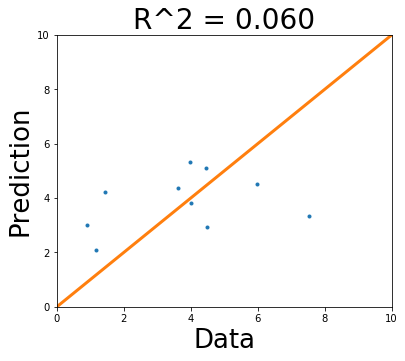

Epoch: 11/3000 Iteration: 1001 Train loss: 0.169
Epoch: 23/3000 Iteration: 2002 Train loss: 0.327
Epoch: 35/3000 Iteration: 3003 Train loss: 1.611
Epoch: 47/3000 Iteration: 4004 Train loss: 0.452
Epoch: 58/3000 Iteration: 5005 Train loss: 0.162
Epoch: 70/3000 Iteration: 6006 Train loss: 0.170
Epoch: 82/3000 Iteration: 7007 Train loss: 0.190
Epoch: 94/3000 Iteration: 8008 Train loss: 1.036
Epoch: 105/3000 Iteration: 9009 Train loss: 0.027
Epoch: 117/3000 Iteration: 10010 Train loss: 0.023
Epoch: 129/3000 Iteration: 11011 Train loss: 0.074
Epoch: 141/3000 Iteration: 12012 Train loss: 0.011
Epoch: 153/3000 Iteration: 13013 Train loss: 0.001
Epoch: 164/3000 Iteration: 14014 Train loss: 0.115
Epoch: 176/3000 Iteration: 15015 Train loss: 1.109
Epoch: 188/3000 Iteration: 16016 Train loss: 0.131
Epoch: 200/3000 Iteration: 17017 Train loss: 0.152
Epoch: 211/3000 Iteration: 18018 Train loss: 0.081
Epoch: 223/3000 Iteration: 19019 Train loss: 0.012
Epoch: 235/3000 Iteration: 20020 Train loss: 0.0

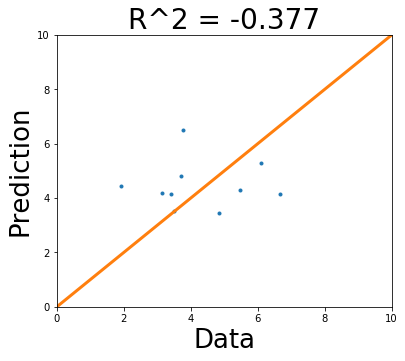

Epoch: 11/3000 Iteration: 1001 Train loss: 2.520
Epoch: 23/3000 Iteration: 2002 Train loss: 0.637
Epoch: 35/3000 Iteration: 3003 Train loss: 0.036
Epoch: 47/3000 Iteration: 4004 Train loss: 0.197
Epoch: 58/3000 Iteration: 5005 Train loss: 0.067
Epoch: 70/3000 Iteration: 6006 Train loss: 0.768
Epoch: 82/3000 Iteration: 7007 Train loss: 0.576
Epoch: 94/3000 Iteration: 8008 Train loss: 0.081
Epoch: 105/3000 Iteration: 9009 Train loss: 0.028
Epoch: 117/3000 Iteration: 10010 Train loss: 0.205
Epoch: 129/3000 Iteration: 11011 Train loss: 0.290
Epoch: 141/3000 Iteration: 12012 Train loss: 0.001
Epoch: 153/3000 Iteration: 13013 Train loss: 0.108
Epoch: 164/3000 Iteration: 14014 Train loss: 0.170
Epoch: 176/3000 Iteration: 15015 Train loss: 0.011
Epoch: 188/3000 Iteration: 16016 Train loss: 0.005
Epoch: 200/3000 Iteration: 17017 Train loss: 0.003
Epoch: 211/3000 Iteration: 18018 Train loss: 0.017
Epoch: 223/3000 Iteration: 19019 Train loss: 0.049
Epoch: 235/3000 Iteration: 20020 Train loss: 0.3

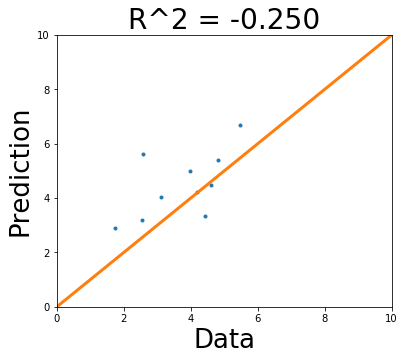

Epoch: 11/3000 Iteration: 1001 Train loss: 0.255
Epoch: 23/3000 Iteration: 2002 Train loss: 0.128
Epoch: 35/3000 Iteration: 3003 Train loss: 0.001
Epoch: 47/3000 Iteration: 4004 Train loss: 0.001
Epoch: 58/3000 Iteration: 5005 Train loss: 1.542
Epoch: 70/3000 Iteration: 6006 Train loss: 0.881
Epoch: 82/3000 Iteration: 7007 Train loss: 0.066
Epoch: 94/3000 Iteration: 8008 Train loss: 0.138
Epoch: 105/3000 Iteration: 9009 Train loss: 0.003
Epoch: 117/3000 Iteration: 10010 Train loss: 0.022
Epoch: 129/3000 Iteration: 11011 Train loss: 0.017
Epoch: 141/3000 Iteration: 12012 Train loss: 0.048
Epoch: 153/3000 Iteration: 13013 Train loss: 0.093
Epoch: 164/3000 Iteration: 14014 Train loss: 0.476
Epoch: 176/3000 Iteration: 15015 Train loss: 0.007
Epoch: 188/3000 Iteration: 16016 Train loss: 0.116
Epoch: 200/3000 Iteration: 17017 Train loss: 0.028
Epoch: 211/3000 Iteration: 18018 Train loss: 0.000
Epoch: 223/3000 Iteration: 19019 Train loss: 0.030
Epoch: 235/3000 Iteration: 20020 Train loss: 0.0

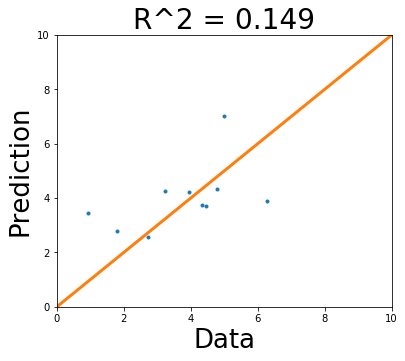

Epoch: 11/3000 Iteration: 1001 Train loss: 0.428
Epoch: 23/3000 Iteration: 2002 Train loss: 0.200
Epoch: 35/3000 Iteration: 3003 Train loss: 1.228
Epoch: 47/3000 Iteration: 4004 Train loss: 0.138
Epoch: 58/3000 Iteration: 5005 Train loss: 1.830
Epoch: 70/3000 Iteration: 6006 Train loss: 0.000
Epoch: 82/3000 Iteration: 7007 Train loss: 0.006
Epoch: 94/3000 Iteration: 8008 Train loss: 0.021
Epoch: 105/3000 Iteration: 9009 Train loss: 0.809
Epoch: 117/3000 Iteration: 10010 Train loss: 0.058
Epoch: 129/3000 Iteration: 11011 Train loss: 0.559
Epoch: 141/3000 Iteration: 12012 Train loss: 0.005
Epoch: 153/3000 Iteration: 13013 Train loss: 0.027
Epoch: 164/3000 Iteration: 14014 Train loss: 0.005
Epoch: 176/3000 Iteration: 15015 Train loss: 0.029
Epoch: 188/3000 Iteration: 16016 Train loss: 0.008
Epoch: 200/3000 Iteration: 17017 Train loss: 0.013
Epoch: 211/3000 Iteration: 18018 Train loss: 0.101
Epoch: 223/3000 Iteration: 19019 Train loss: 0.147
Epoch: 235/3000 Iteration: 20020 Train loss: 0.0

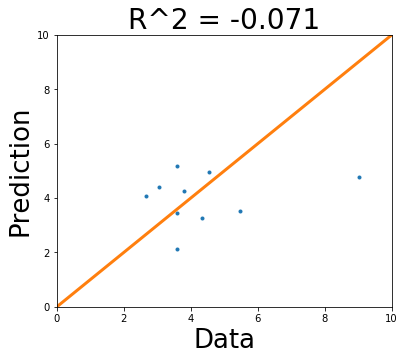

Epoch: 11/3000 Iteration: 1001 Train loss: 0.088
Epoch: 23/3000 Iteration: 2002 Train loss: 0.266
Epoch: 34/3000 Iteration: 3003 Train loss: 1.141
Epoch: 46/3000 Iteration: 4004 Train loss: 0.344
Epoch: 58/3000 Iteration: 5005 Train loss: 0.002
Epoch: 69/3000 Iteration: 6006 Train loss: 0.131
Epoch: 81/3000 Iteration: 7007 Train loss: 0.042
Epoch: 93/3000 Iteration: 8008 Train loss: 0.234
Epoch: 104/3000 Iteration: 9009 Train loss: 0.034
Epoch: 116/3000 Iteration: 10010 Train loss: 0.042
Epoch: 128/3000 Iteration: 11011 Train loss: 0.027
Epoch: 139/3000 Iteration: 12012 Train loss: 0.142
Epoch: 151/3000 Iteration: 13013 Train loss: 0.010
Epoch: 162/3000 Iteration: 14014 Train loss: 0.020
Epoch: 174/3000 Iteration: 15015 Train loss: 0.031
Epoch: 186/3000 Iteration: 16016 Train loss: 0.005
Epoch: 197/3000 Iteration: 17017 Train loss: 0.002
Epoch: 209/3000 Iteration: 18018 Train loss: 0.056
Epoch: 221/3000 Iteration: 19019 Train loss: 0.034
Epoch: 232/3000 Iteration: 20020 Train loss: 0.2

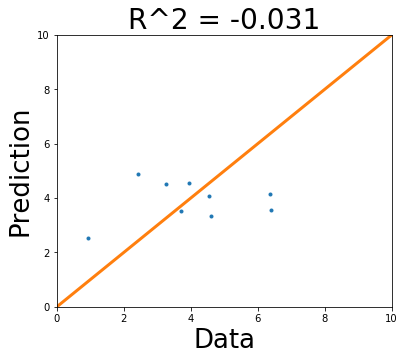

Epoch: 11/3000 Iteration: 1001 Train loss: 0.135
Epoch: 23/3000 Iteration: 2002 Train loss: 4.936
Epoch: 34/3000 Iteration: 3003 Train loss: 1.509
Epoch: 46/3000 Iteration: 4004 Train loss: 0.521
Epoch: 58/3000 Iteration: 5005 Train loss: 0.332
Epoch: 69/3000 Iteration: 6006 Train loss: 0.265
Epoch: 81/3000 Iteration: 7007 Train loss: 0.017
Epoch: 93/3000 Iteration: 8008 Train loss: 0.035
Epoch: 104/3000 Iteration: 9009 Train loss: 0.016
Epoch: 116/3000 Iteration: 10010 Train loss: 0.004
Epoch: 128/3000 Iteration: 11011 Train loss: 0.015
Epoch: 139/3000 Iteration: 12012 Train loss: 0.151
Epoch: 151/3000 Iteration: 13013 Train loss: 0.546
Epoch: 162/3000 Iteration: 14014 Train loss: 0.038
Epoch: 174/3000 Iteration: 15015 Train loss: 0.053
Epoch: 186/3000 Iteration: 16016 Train loss: 0.257
Epoch: 197/3000 Iteration: 17017 Train loss: 0.522
Epoch: 209/3000 Iteration: 18018 Train loss: 0.061
Epoch: 221/3000 Iteration: 19019 Train loss: 0.016
Epoch: 232/3000 Iteration: 20020 Train loss: 0.7

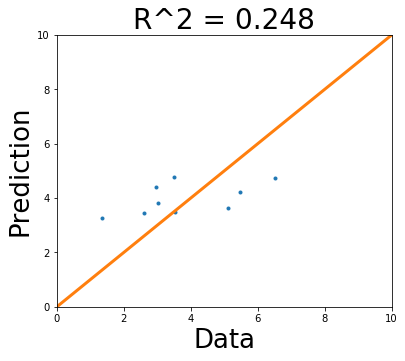

Epoch: 11/3000 Iteration: 1001 Train loss: 0.406
Epoch: 23/3000 Iteration: 2002 Train loss: 0.904
Epoch: 34/3000 Iteration: 3003 Train loss: 0.322
Epoch: 46/3000 Iteration: 4004 Train loss: 0.323
Epoch: 58/3000 Iteration: 5005 Train loss: 0.119
Epoch: 69/3000 Iteration: 6006 Train loss: 0.267
Epoch: 81/3000 Iteration: 7007 Train loss: 0.015
Epoch: 93/3000 Iteration: 8008 Train loss: 0.026
Epoch: 104/3000 Iteration: 9009 Train loss: 0.044
Epoch: 116/3000 Iteration: 10010 Train loss: 0.038
Epoch: 128/3000 Iteration: 11011 Train loss: 0.055
Epoch: 139/3000 Iteration: 12012 Train loss: 0.155
Epoch: 151/3000 Iteration: 13013 Train loss: 0.002
Epoch: 162/3000 Iteration: 14014 Train loss: 0.009
Epoch: 174/3000 Iteration: 15015 Train loss: 0.502
Epoch: 186/3000 Iteration: 16016 Train loss: 0.000
Epoch: 197/3000 Iteration: 17017 Train loss: 0.081
Epoch: 209/3000 Iteration: 18018 Train loss: 0.146
Epoch: 221/3000 Iteration: 19019 Train loss: 0.037
Epoch: 232/3000 Iteration: 20020 Train loss: 0.0

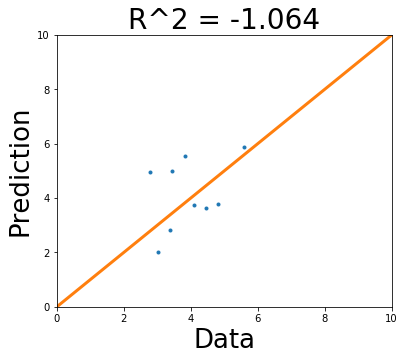

Epoch: 11/3000 Iteration: 1001 Train loss: 0.074
Epoch: 23/3000 Iteration: 2002 Train loss: 0.418
Epoch: 34/3000 Iteration: 3003 Train loss: 0.972
Epoch: 46/3000 Iteration: 4004 Train loss: 0.001
Epoch: 58/3000 Iteration: 5005 Train loss: 0.300
Epoch: 69/3000 Iteration: 6006 Train loss: 0.001
Epoch: 81/3000 Iteration: 7007 Train loss: 0.053
Epoch: 93/3000 Iteration: 8008 Train loss: 0.001
Epoch: 104/3000 Iteration: 9009 Train loss: 0.005
Epoch: 116/3000 Iteration: 10010 Train loss: 0.043
Epoch: 128/3000 Iteration: 11011 Train loss: 0.012
Epoch: 139/3000 Iteration: 12012 Train loss: 0.151
Epoch: 151/3000 Iteration: 13013 Train loss: 0.083
Epoch: 162/3000 Iteration: 14014 Train loss: 0.079
Epoch: 174/3000 Iteration: 15015 Train loss: 0.545
Epoch: 186/3000 Iteration: 16016 Train loss: 0.001
Epoch: 197/3000 Iteration: 17017 Train loss: 0.118
Epoch: 209/3000 Iteration: 18018 Train loss: 0.022
Epoch: 221/3000 Iteration: 19019 Train loss: 0.003
Epoch: 232/3000 Iteration: 20020 Train loss: 0.4

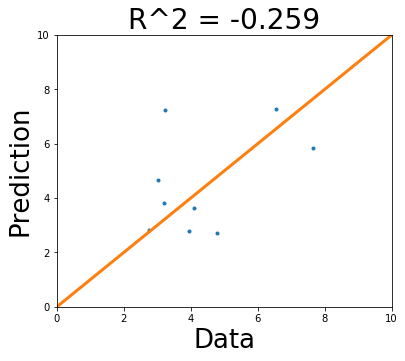

Epoch: 11/3000 Iteration: 1001 Train loss: 0.228
Epoch: 23/3000 Iteration: 2002 Train loss: 1.228
Epoch: 34/3000 Iteration: 3003 Train loss: 8.058
Epoch: 46/3000 Iteration: 4004 Train loss: 0.683
Epoch: 58/3000 Iteration: 5005 Train loss: 0.178
Epoch: 69/3000 Iteration: 6006 Train loss: 0.734
Epoch: 81/3000 Iteration: 7007 Train loss: 0.009
Epoch: 93/3000 Iteration: 8008 Train loss: 0.072
Epoch: 104/3000 Iteration: 9009 Train loss: 0.248
Epoch: 116/3000 Iteration: 10010 Train loss: 0.000
Epoch: 128/3000 Iteration: 11011 Train loss: 0.000
Epoch: 139/3000 Iteration: 12012 Train loss: 0.001
Epoch: 151/3000 Iteration: 13013 Train loss: 0.005
Epoch: 162/3000 Iteration: 14014 Train loss: 0.747
Epoch: 174/3000 Iteration: 15015 Train loss: 0.052
Epoch: 186/3000 Iteration: 16016 Train loss: 0.013
Epoch: 197/3000 Iteration: 17017 Train loss: 0.002
Epoch: 209/3000 Iteration: 18018 Train loss: 0.067
Epoch: 221/3000 Iteration: 19019 Train loss: 0.082
Epoch: 232/3000 Iteration: 20020 Train loss: 0.3

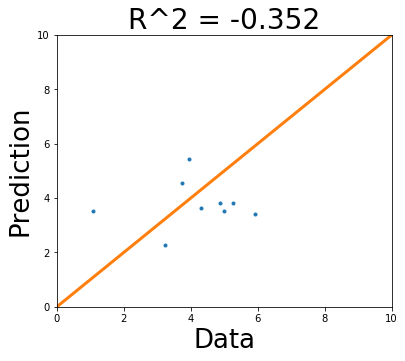

In [31]:
"""
k-fold cross validation
    parameter# n_splits: refers to number of folds
"""

kf = KFold(n_splits=10, shuffle=True, random_state=33)

for train_index, test_index in kf.split(whole_x):
    """
    build the LSTM
        parameter# keep_prob: probability to use layer node. done to avoid overfitting
        parameter# lstm: network
        
        LSTM used:
            BasicLSTMCell: standard RNN
            GRUCell: gated recyrrent units. model is simpler that standard LSTM and require less parameters
    """
    
    # Create the graph object
    graph = tf.Graph()
    # Add nodes to the graph
    with graph.as_default():
        inputs_ = tf.placeholder(tf.int32, [None, None], name='inputs')
        labels_ = tf.placeholder(tf.float32, [None, None], name='labels')
        keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    
    with graph.as_default():
        # Your basic LSTM/GRU cell (choose one below)
        lstm = tf.contrib.rnn.GRUCell(lstm_size)
        # lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
        
        # Add dropout to the cell
        drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
        
        # Stack up multiple LSTM layers, for deep learning
        cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
        
        # Getting an initial state of all zeros
        initial_state = cell.zero_state(batch_size, tf.float32)
    
    with graph.as_default():
        # one hot encoding
        one_hot_code = tf.one_hot(inputs_, 20)
        outputs, final_state = tf.nn.dynamic_rnn(cell, one_hot_code, initial_state=initial_state)
    
    with graph.as_default():
        # get the prediction from the final output
        # using RELU as the nonlinear function
        # initialize the weight matrix using truncated normal distribution
        
        predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1, activation_fn=tf.nn.relu,
                                                        weights_initializer=tf.truncated_normal_initializer(stddev=0.1))
        
        # minimize the mean squared error
        cost = tf.losses.mean_squared_error(labels_, predictions)
        
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    with graph.as_default():
        accuracy = tf.losses.mean_squared_error(labels_, predictions)
    
    with graph.as_default():
        saver = tf.train.Saver()
    
    iteration = 1
    
    with tf.Session(graph=graph) as sess:
        
        """
        LSTM training section
        """
        sess.run(tf.global_variables_initializer())
        
        for e in range(epochs):
            state = sess.run(initial_state)
            
            for x, y in get_batches(whole_x[train_index], whole_y[train_index], batch_size):
                feed = {
                    inputs_:       x,
                    labels_:       y[:, None],
                    keep_prob:     0.8,
                    initial_state: state
                }
                loss, _, _ = sess.run([cost, final_state, optimizer], feed_dict=feed)
                
                # output some training error every 1000 steps
                if iteration % 1000 == 0:
                    print("Epoch: {}/{}".format(e, epochs),
                          "Iteration: {}".format(iteration),
                          "Train loss: {:.3f}".format(loss))
                
                iteration += 1
        
        """
        LSTM based prediction
        
        variable# data_y:    value of tail response
        variable# predict_y: prediction of tail response
        """
        .
        data_y = []
        predict_y = []
        
        val_state = sess.run(cell.zero_state(batch_size, tf.float32))
        for x, y in get_batches(whole_x[test_index], whole_y[test_index], batch_size):
            feed = {
                inputs_:       x,
                keep_prob:     1,
                initial_state: val_state
            }
            prediction, _ = sess.run([predictions, final_state], feed_dict=feed)
            
            data_y.append(y)
            predict_y.append(prediction)
        
        data_y = np.ravel(data_y)
        predict_y = np.ravel(predict_y)
        
        plt.figure(figsize=(6, 5))
        plt.plot(data_y, predict_y, '.')
        plt.xlim(0, 10)
        plt.ylim(0, 10)
        
        plt.xlabel('Data', fontsize=26)
        plt.ylabel('Prediction', fontsize=26)
        plt.plot((0, 10), (0, 10), lw=3)
        
        # output the score by R squared or MSE
        
        #plt.title('R^2 = %.3f' %r2_score(data_y, predict_y), fontsize = 28)
        plt.title('R^2 = %.3f' % MSE(data_y, predict_y), fontsize=28)
        plt.show()


#Iteration 2

Epoch: 11/500 Iteration: 1001 Train loss: 2.779
Epoch: 23/500 Iteration: 2002 Train loss: 0.146
Epoch: 35/500 Iteration: 3003 Train loss: 0.244
Epoch: 47/500 Iteration: 4004 Train loss: 0.290
Epoch: 58/500 Iteration: 5005 Train loss: 0.108
Epoch: 70/500 Iteration: 6006 Train loss: 0.035
Epoch: 82/500 Iteration: 7007 Train loss: 0.150
Epoch: 94/500 Iteration: 8008 Train loss: 0.147
Epoch: 105/500 Iteration: 9009 Train loss: 0.107
Epoch: 117/500 Iteration: 10010 Train loss: 0.022
Epoch: 129/500 Iteration: 11011 Train loss: 0.028
Epoch: 141/500 Iteration: 12012 Train loss: 0.010
Epoch: 153/500 Iteration: 13013 Train loss: 0.038
Epoch: 164/500 Iteration: 14014 Train loss: 0.047
Epoch: 176/500 Iteration: 15015 Train loss: 0.188
Epoch: 188/500 Iteration: 16016 Train loss: 0.028
Epoch: 200/500 Iteration: 17017 Train loss: 0.029
Epoch: 211/500 Iteration: 18018 Train loss: 0.077
Epoch: 223/500 Iteration: 19019 Train loss: 0.022
Epoch: 235/500 Iteration: 20020 Train loss: 0.201
Epoch: 247/500 It

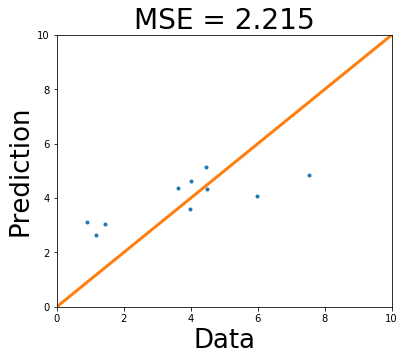

Epoch: 11/500 Iteration: 1001 Train loss: 0.013
Epoch: 23/500 Iteration: 2002 Train loss: 0.024
Epoch: 35/500 Iteration: 3003 Train loss: 2.631
Epoch: 47/500 Iteration: 4004 Train loss: 0.548
Epoch: 58/500 Iteration: 5005 Train loss: 0.201
Epoch: 70/500 Iteration: 6006 Train loss: 0.242
Epoch: 82/500 Iteration: 7007 Train loss: 0.234
Epoch: 94/500 Iteration: 8008 Train loss: 0.033
Epoch: 105/500 Iteration: 9009 Train loss: 0.005
Epoch: 117/500 Iteration: 10010 Train loss: 0.052
Epoch: 129/500 Iteration: 11011 Train loss: 0.414
Epoch: 141/500 Iteration: 12012 Train loss: 0.003
Epoch: 153/500 Iteration: 13013 Train loss: 0.316
Epoch: 164/500 Iteration: 14014 Train loss: 0.003
Epoch: 176/500 Iteration: 15015 Train loss: 0.271
Epoch: 188/500 Iteration: 16016 Train loss: 0.507
Epoch: 200/500 Iteration: 17017 Train loss: 0.025
Epoch: 211/500 Iteration: 18018 Train loss: 0.006
Epoch: 223/500 Iteration: 19019 Train loss: 0.137
Epoch: 235/500 Iteration: 20020 Train loss: 0.458
Epoch: 247/500 It

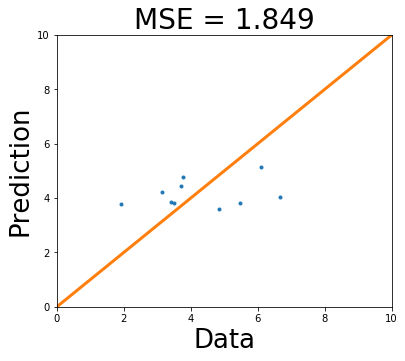

Epoch: 11/500 Iteration: 1001 Train loss: 5.105
Epoch: 23/500 Iteration: 2002 Train loss: 0.671
Epoch: 35/500 Iteration: 3003 Train loss: 0.006
Epoch: 47/500 Iteration: 4004 Train loss: 0.305
Epoch: 58/500 Iteration: 5005 Train loss: 0.063
Epoch: 70/500 Iteration: 6006 Train loss: 0.003
Epoch: 82/500 Iteration: 7007 Train loss: 1.293
Epoch: 94/500 Iteration: 8008 Train loss: 0.000
Epoch: 105/500 Iteration: 9009 Train loss: 0.318
Epoch: 117/500 Iteration: 10010 Train loss: 0.012
Epoch: 129/500 Iteration: 11011 Train loss: 2.035
Epoch: 141/500 Iteration: 12012 Train loss: 0.001
Epoch: 153/500 Iteration: 13013 Train loss: 2.682
Epoch: 164/500 Iteration: 14014 Train loss: 0.276
Epoch: 176/500 Iteration: 15015 Train loss: 0.160
Epoch: 188/500 Iteration: 16016 Train loss: 0.010
Epoch: 200/500 Iteration: 17017 Train loss: 0.002
Epoch: 211/500 Iteration: 18018 Train loss: 0.044
Epoch: 223/500 Iteration: 19019 Train loss: 0.000
Epoch: 235/500 Iteration: 20020 Train loss: 0.000
Epoch: 247/500 It

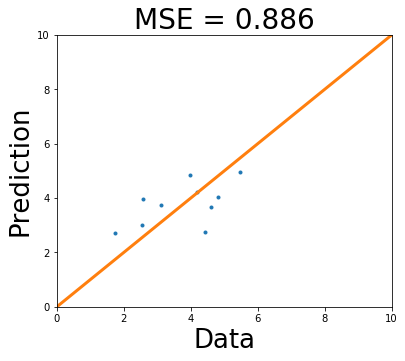

Epoch: 11/500 Iteration: 1001 Train loss: 0.749
Epoch: 23/500 Iteration: 2002 Train loss: 0.414
Epoch: 35/500 Iteration: 3003 Train loss: 0.153
Epoch: 47/500 Iteration: 4004 Train loss: 0.124
Epoch: 58/500 Iteration: 5005 Train loss: 0.039
Epoch: 70/500 Iteration: 6006 Train loss: 0.047
Epoch: 82/500 Iteration: 7007 Train loss: 0.019
Epoch: 94/500 Iteration: 8008 Train loss: 0.144
Epoch: 105/500 Iteration: 9009 Train loss: 0.031
Epoch: 117/500 Iteration: 10010 Train loss: 0.000
Epoch: 129/500 Iteration: 11011 Train loss: 0.050
Epoch: 141/500 Iteration: 12012 Train loss: 0.026
Epoch: 153/500 Iteration: 13013 Train loss: 0.202
Epoch: 164/500 Iteration: 14014 Train loss: 0.410
Epoch: 176/500 Iteration: 15015 Train loss: 0.008
Epoch: 188/500 Iteration: 16016 Train loss: 0.000
Epoch: 200/500 Iteration: 17017 Train loss: 0.014
Epoch: 211/500 Iteration: 18018 Train loss: 0.040
Epoch: 223/500 Iteration: 19019 Train loss: 0.128
Epoch: 235/500 Iteration: 20020 Train loss: 0.103
Epoch: 247/500 It

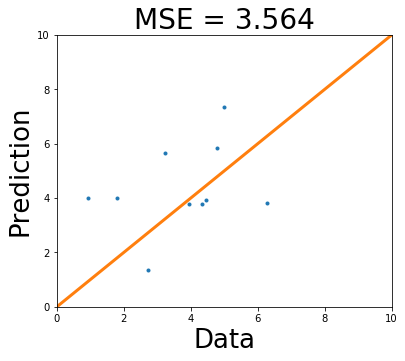

Epoch: 11/500 Iteration: 1001 Train loss: 0.002
Epoch: 23/500 Iteration: 2002 Train loss: 0.013
Epoch: 35/500 Iteration: 3003 Train loss: 0.789
Epoch: 47/500 Iteration: 4004 Train loss: 0.067
Epoch: 58/500 Iteration: 5005 Train loss: 0.134
Epoch: 70/500 Iteration: 6006 Train loss: 0.072
Epoch: 82/500 Iteration: 7007 Train loss: 0.154
Epoch: 94/500 Iteration: 8008 Train loss: 0.010
Epoch: 105/500 Iteration: 9009 Train loss: 0.002
Epoch: 117/500 Iteration: 10010 Train loss: 0.011
Epoch: 129/500 Iteration: 11011 Train loss: 0.012
Epoch: 141/500 Iteration: 12012 Train loss: 0.250
Epoch: 153/500 Iteration: 13013 Train loss: 0.045
Epoch: 164/500 Iteration: 14014 Train loss: 0.573
Epoch: 176/500 Iteration: 15015 Train loss: 0.073
Epoch: 188/500 Iteration: 16016 Train loss: 0.794
Epoch: 200/500 Iteration: 17017 Train loss: 0.082
Epoch: 211/500 Iteration: 18018 Train loss: 0.391
Epoch: 223/500 Iteration: 19019 Train loss: 0.078
Epoch: 235/500 Iteration: 20020 Train loss: 0.280
Epoch: 247/500 It

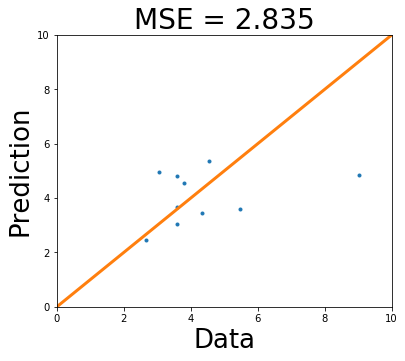

Epoch: 11/500 Iteration: 1001 Train loss: 2.669
Epoch: 23/500 Iteration: 2002 Train loss: 2.707
Epoch: 34/500 Iteration: 3003 Train loss: 0.004
Epoch: 46/500 Iteration: 4004 Train loss: 0.055
Epoch: 58/500 Iteration: 5005 Train loss: 0.005
Epoch: 69/500 Iteration: 6006 Train loss: 0.025
Epoch: 81/500 Iteration: 7007 Train loss: 0.438
Epoch: 93/500 Iteration: 8008 Train loss: 0.041
Epoch: 104/500 Iteration: 9009 Train loss: 0.192
Epoch: 116/500 Iteration: 10010 Train loss: 0.002
Epoch: 128/500 Iteration: 11011 Train loss: 0.183
Epoch: 139/500 Iteration: 12012 Train loss: 0.271
Epoch: 151/500 Iteration: 13013 Train loss: 0.740
Epoch: 162/500 Iteration: 14014 Train loss: 0.155
Epoch: 174/500 Iteration: 15015 Train loss: 0.121
Epoch: 186/500 Iteration: 16016 Train loss: 0.219
Epoch: 197/500 Iteration: 17017 Train loss: 0.011
Epoch: 209/500 Iteration: 18018 Train loss: 0.109
Epoch: 221/500 Iteration: 19019 Train loss: 0.000
Epoch: 232/500 Iteration: 20020 Train loss: 0.838
Epoch: 244/500 It

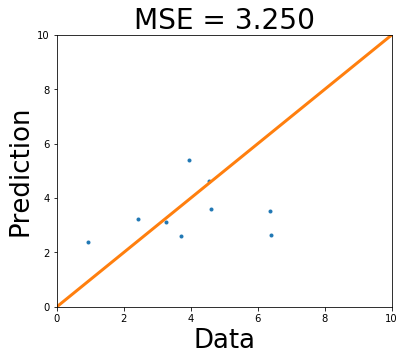

Epoch: 11/500 Iteration: 1001 Train loss: 1.677
Epoch: 23/500 Iteration: 2002 Train loss: 7.524
Epoch: 34/500 Iteration: 3003 Train loss: 0.954
Epoch: 46/500 Iteration: 4004 Train loss: 0.608
Epoch: 58/500 Iteration: 5005 Train loss: 0.113
Epoch: 69/500 Iteration: 6006 Train loss: 0.028
Epoch: 81/500 Iteration: 7007 Train loss: 0.088
Epoch: 93/500 Iteration: 8008 Train loss: 0.161
Epoch: 104/500 Iteration: 9009 Train loss: 0.219
Epoch: 116/500 Iteration: 10010 Train loss: 0.201
Epoch: 128/500 Iteration: 11011 Train loss: 0.755
Epoch: 139/500 Iteration: 12012 Train loss: 0.002
Epoch: 151/500 Iteration: 13013 Train loss: 0.210
Epoch: 162/500 Iteration: 14014 Train loss: 0.029
Epoch: 174/500 Iteration: 15015 Train loss: 0.027
Epoch: 186/500 Iteration: 16016 Train loss: 0.084
Epoch: 197/500 Iteration: 17017 Train loss: 0.196
Epoch: 209/500 Iteration: 18018 Train loss: 0.930
Epoch: 221/500 Iteration: 19019 Train loss: 0.089
Epoch: 232/500 Iteration: 20020 Train loss: 0.698
Epoch: 244/500 It

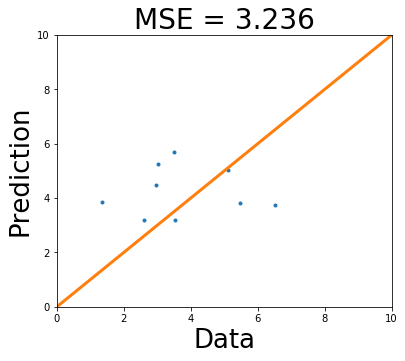

Epoch: 11/500 Iteration: 1001 Train loss: 2.049
Epoch: 23/500 Iteration: 2002 Train loss: 2.386
Epoch: 34/500 Iteration: 3003 Train loss: 0.011
Epoch: 46/500 Iteration: 4004 Train loss: 0.643
Epoch: 58/500 Iteration: 5005 Train loss: 0.342
Epoch: 69/500 Iteration: 6006 Train loss: 0.022
Epoch: 81/500 Iteration: 7007 Train loss: 0.001
Epoch: 93/500 Iteration: 8008 Train loss: 0.003
Epoch: 104/500 Iteration: 9009 Train loss: 0.155
Epoch: 116/500 Iteration: 10010 Train loss: 0.226
Epoch: 128/500 Iteration: 11011 Train loss: 0.002
Epoch: 139/500 Iteration: 12012 Train loss: 0.175
Epoch: 151/500 Iteration: 13013 Train loss: 0.302
Epoch: 162/500 Iteration: 14014 Train loss: 0.270
Epoch: 174/500 Iteration: 15015 Train loss: 0.600
Epoch: 186/500 Iteration: 16016 Train loss: 0.155
Epoch: 197/500 Iteration: 17017 Train loss: 0.133
Epoch: 209/500 Iteration: 18018 Train loss: 0.010
Epoch: 221/500 Iteration: 19019 Train loss: 0.023
Epoch: 232/500 Iteration: 20020 Train loss: 0.809
Epoch: 244/500 It

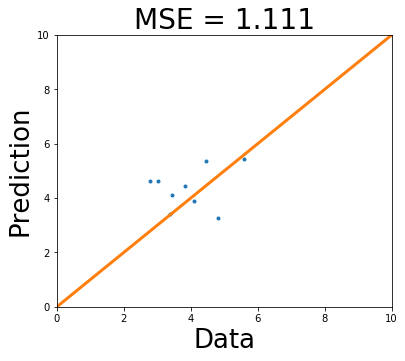

Epoch: 11/500 Iteration: 1001 Train loss: 0.969
Epoch: 23/500 Iteration: 2002 Train loss: 3.800
Epoch: 34/500 Iteration: 3003 Train loss: 0.000
Epoch: 46/500 Iteration: 4004 Train loss: 0.201
Epoch: 58/500 Iteration: 5005 Train loss: 1.164
Epoch: 69/500 Iteration: 6006 Train loss: 0.158
Epoch: 81/500 Iteration: 7007 Train loss: 0.032
Epoch: 93/500 Iteration: 8008 Train loss: 0.000
Epoch: 104/500 Iteration: 9009 Train loss: 0.066
Epoch: 116/500 Iteration: 10010 Train loss: 0.004
Epoch: 128/500 Iteration: 11011 Train loss: 0.459
Epoch: 139/500 Iteration: 12012 Train loss: 0.005
Epoch: 151/500 Iteration: 13013 Train loss: 1.104
Epoch: 162/500 Iteration: 14014 Train loss: 0.032
Epoch: 174/500 Iteration: 15015 Train loss: 0.163
Epoch: 186/500 Iteration: 16016 Train loss: 0.337
Epoch: 197/500 Iteration: 17017 Train loss: 0.013
Epoch: 209/500 Iteration: 18018 Train loss: 0.036
Epoch: 221/500 Iteration: 19019 Train loss: 0.008
Epoch: 232/500 Iteration: 20020 Train loss: 1.547
Epoch: 244/500 It

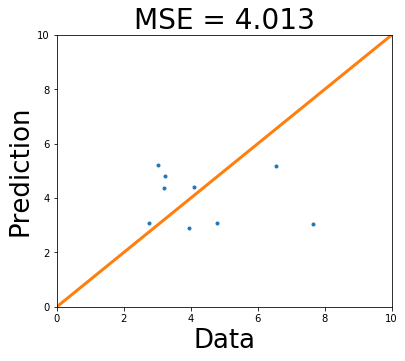

Epoch: 11/500 Iteration: 1001 Train loss: 3.870
Epoch: 23/500 Iteration: 2002 Train loss: 0.439
Epoch: 34/500 Iteration: 3003 Train loss: 0.290
Epoch: 46/500 Iteration: 4004 Train loss: 0.028
Epoch: 58/500 Iteration: 5005 Train loss: 0.004
Epoch: 69/500 Iteration: 6006 Train loss: 0.367
Epoch: 81/500 Iteration: 7007 Train loss: 0.001
Epoch: 93/500 Iteration: 8008 Train loss: 0.186
Epoch: 104/500 Iteration: 9009 Train loss: 0.025
Epoch: 116/500 Iteration: 10010 Train loss: 0.061
Epoch: 128/500 Iteration: 11011 Train loss: 0.596
Epoch: 139/500 Iteration: 12012 Train loss: 0.036
Epoch: 151/500 Iteration: 13013 Train loss: 0.025
Epoch: 162/500 Iteration: 14014 Train loss: 0.005
Epoch: 174/500 Iteration: 15015 Train loss: 0.228
Epoch: 186/500 Iteration: 16016 Train loss: 0.099
Epoch: 197/500 Iteration: 17017 Train loss: 0.047
Epoch: 209/500 Iteration: 18018 Train loss: 0.354
Epoch: 221/500 Iteration: 19019 Train loss: 0.220
Epoch: 232/500 Iteration: 20020 Train loss: 0.758
Epoch: 244/500 It

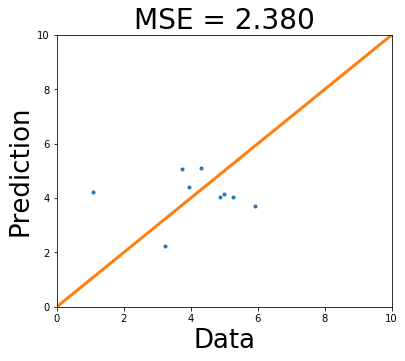

In [44]:
# just another test, can be deleted

kf = KFold(n_splits=10, shuffle=True, random_state=33)

for train_index, test_index in kf.split(whole_x):
    # Create the graph object
    graph = tf.Graph()
    # Add nodes to the graph
    with graph.as_default():
        inputs_ = tf.placeholder(tf.int32, [None, None], name='inputs')
        labels_ = tf.placeholder(tf.float32, [None, None], name='labels')
        keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    
    with graph.as_default():
        # Your basic LSTM cell
        lstm = tf.contrib.rnn.GRUCell(lstm_size)
        
        # Add dropout to the cell
        drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
        
        # Stack up multiple LSTM layers, for deep learning
        cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
        
        # Getting an initial state of all zeros
        initial_state = cell.zero_state(batch_size, tf.float32)
    
    with graph.as_default():
        one_hot_code = tf.one_hot(inputs_, 20)
        outputs, final_state = tf.nn.dynamic_rnn(cell, one_hot_code, initial_state=initial_state)
    
    with graph.as_default():
        predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1,
                                                        activation_fn=tf.nn.relu,
                                                        weights_initializer=tf.truncated_normal_initializer(stddev=0.1))
        
        cost = tf.losses.mean_squared_error(labels_, predictions)
        
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    with graph.as_default():
        accuracy = tf.losses.mean_squared_error(labels_, predictions)
    
    with graph.as_default():
        saver = tf.train.Saver()
    
    epochs = 500
    iteration = 1
    
    with tf.Session(graph=graph) as sess:
        sess.run(tf.global_variables_initializer())
        
        for e in range(epochs):
            state = sess.run(initial_state)
            
            for x, y in get_batches(whole_x[train_index], whole_y[train_index], batch_size):
                feed = {
                    inputs_:       x,
                    labels_:       y[:, None],
                    keep_prob:     0.5,
                    initial_state: state
                }
                loss, _, _ = sess.run([cost, final_state, optimizer], feed_dict=feed)
                if iteration % 1001 == 0:
                    print("Epoch: {}/{}".format(e, epochs),
                          "Iteration: {}".format(iteration),
                          "Train loss: {:.3f}".format(loss))
                
                iteration += 1
        
        data_y = []
        predict_y = []
        
        val_state = sess.run(cell.zero_state(batch_size, tf.float32))
        for x, y in get_batches(whole_x[test_index], whole_y[test_index], batch_size):
            feed = {
                inputs_:       x,
                keep_prob:     1,
                initial_state: val_state
            }
            prediction, _ = sess.run([predictions, final_state], feed_dict=feed)
            
            data_y.append(y)
            predict_y.append(prediction)
        
        data_y = np.ravel(data_y)
        predict_y = np.ravel(predict_y)
        
        plt.figure(figsize=(6, 5))
        plt.plot(data_y, predict_y, '.')
        plt.xlim(0, 10)
        plt.ylim(0, 10)
        
        plt.xlabel('Data', fontsize=26)
        plt.ylabel('Prediction', fontsize=26)
        plt.plot((0, 10), (0, 10), lw=3)
        
        plt.title('MSE = %.3f' % MSE(data_y, predict_y), fontsize=28)
        plt.show()


training and prediction on all data
--------

Epoch: 10/500 Iteration: 1001 Train loss: 0.919
Epoch: 21/500 Iteration: 2002 Train loss: 3.712
Epoch: 31/500 Iteration: 3003 Train loss: 2.724
Epoch: 42/500 Iteration: 4004 Train loss: 3.402
Epoch: 52/500 Iteration: 5005 Train loss: 0.001
Epoch: 63/500 Iteration: 6006 Train loss: 0.236
Epoch: 73/500 Iteration: 7007 Train loss: 0.040
Epoch: 84/500 Iteration: 8008 Train loss: 0.445
Epoch: 94/500 Iteration: 9009 Train loss: 0.000
Epoch: 105/500 Iteration: 10010 Train loss: 0.085
Epoch: 115/500 Iteration: 11011 Train loss: 0.003
Epoch: 126/500 Iteration: 12012 Train loss: 0.017
Epoch: 136/500 Iteration: 13013 Train loss: 0.087
Epoch: 147/500 Iteration: 14014 Train loss: 0.043
Epoch: 158/500 Iteration: 15015 Train loss: 0.816
Epoch: 168/500 Iteration: 16016 Train loss: 0.145
Epoch: 179/500 Iteration: 17017 Train loss: 0.049
Epoch: 189/500 Iteration: 18018 Train loss: 0.423
Epoch: 200/500 Iteration: 19019 Train loss: 0.009
Epoch: 210/500 Iteration: 20020 Train loss: 0.159
Epoch: 221/500 Ite

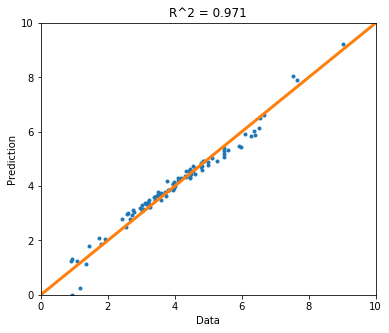

In [45]:
# Create the graph object
graph = tf.Graph()
# Add nodes to the graph
with graph.as_default():
    inputs_ = tf.placeholder(tf.int32, [None, None], name='inputs')
    labels_ = tf.placeholder(tf.float32, [None, None], name='labels')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

with graph.as_default():
    # Your basic LSTM cell
    lstm = tf.contrib.rnn.GRUCell(lstm_size)
    
    # Add dropout to the cell
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    
    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)

with graph.as_default():
    one_hot_code = tf.one_hot(inputs_, 20)
    outputs, final_state = tf.nn.dynamic_rnn(cell, one_hot_code, initial_state=initial_state)

with graph.as_default():
    predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1, activation_fn=tf.nn.relu,
                                                    weights_initializer=tf.truncated_normal_initializer(stddev=0.1))
    
    cost = tf.losses.mean_squared_error(labels_, predictions)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

with graph.as_default():
    accuracy = tf.losses.mean_squared_error(labels_, predictions)

with graph.as_default():
    saver = tf.train.Saver()

epochs = 500

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    for e in range(epochs):
        state = sess.run(initial_state)
        
        for x, y in get_batches(whole_x, whole_y, batch_size):
            feed = {
                inputs_:       x,
                labels_:       y[:, None],
                keep_prob:     0.5,
                initial_state: state
            }
            loss, _, _ = sess.run([cost, final_state, optimizer], feed_dict=feed)
            
            if iteration % 1001 == 0:
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(loss))
            
            #             if iteration%100==0:
            #                 val_acc = []
            #                 val_state = sess.run(cell.zero_state(batch_size, tf.float32))
            #                 for x, y in get_batches(val_x, val_y, batch_size):
            #                     feed = {inputs_: x,
            #                             labels_: y[:, None],
            #                             keep_prob: 1,
            #                             initial_state: val_state}
            #                     batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
            #                     val_acc.append(batch_acc)
            #                 print("Val acc: {:.3f}".format(np.mean(val_acc)))
            iteration += 1
    
    data_y = []
    predict_y = []
    val_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for x, y in get_batches(whole_x, whole_y, batch_size):
        feed = {
            inputs_:       x,
            keep_prob:     1,
            initial_state: val_state
        }
        prediction, _ = sess.run([predictions, final_state], feed_dict=feed)
        
        data_y.append(y)
        predict_y.append(prediction)
    
    data_y = np.ravel(data_y)
    predict_y = np.ravel(predict_y)
    
    plt.figure(figsize=(6, 5))
    plt.plot(data_y, predict_y, '.')
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    
    plt.xlabel('Data')
    plt.ylabel('Prediction')
    plt.plot((0, 10), (0, 10), lw=3)
    
    plt.title('R^2 = %.3f' % r2_score(data_y, predict_y))
    plt.show()
    
    # save the model so that it can be used later
    saver.save(sess, "checkpoints/sentiment.ckpt")


In [47]:
MSE(predict_y, data_y)

0.06792687568045816

prediction for new sequence
-----------

In [48]:
from collections import Counter
from itertools import product

In [49]:
# get the a.a. that appears more than twice in the data
from typing import List, Any

all_possibility = [[] for _ in range(7)]  # type: List[List[Any]]

for i in range(7):
    al = [aa2num2[x[i]] for x in df['tail']]
    counter = Counter(al)
    all_possibility[i] = [key for key in counter if counter[key] > 2]

In [50]:
all_possibility

[[2, 3, 4, 5, 6, 7, 8, 10, 11, 15, 16, 18, 19],
 [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 15, 16, 19],
 [0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 14, 15, 18, 19],
 [3, 4, 7, 8, 10, 11, 14],
 [1, 2, 6, 8, 14, 15, 19],
 [8, 15],
 [9, 6]]

In [51]:
result_all = {}

with tf.Session(graph=graph) as sess:
    # load the saved model
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    val_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for x in product(*all_possibility):
        feed = {inputs_: [x],
                keep_prob: 1,
                initial_state: val_state}
        prediction, _ = sess.run([predictions, final_state], feed_dict=feed)
        
        seq = ''.join([num2aa[s] for s in x])
        result_all[seq] = prediction
        
        #print(seq, prediction[0][0])

In [52]:
# sort the result
sorted_Result = sorted(result_all.items(), key = lambda pair: (pair[1], pair[0]), reverse = True)

In [53]:
import pickle


def dump_file(filename, data):
    f = open(filename, 'wb')
    pickle.dump(data, f)
    f.close()

In [54]:
# all_predict_gru500.pkl is for GRU model trained for 500 steps
# all_predict_lstm3000.pkl is for LSTM model trained for 3000 steps

# dump_file('all_predict_gru500.pkl', result_all)

In [55]:
pprint.pprint(sorted_Result[:50])

[('KKKHTEL', array([[ 9.36091423]], dtype=float32)),
 ('KKKHTDF', array([[ 9.28385544]], dtype=float32)),
 ('KKKHAEL', array([[ 9.27402496]], dtype=float32)),
 ('KKKHTDL', array([[ 9.26696873]], dtype=float32)),
 ('KKKHAEF', array([[ 9.26160908]], dtype=float32)),
 ('KKKHADL', array([[ 9.25163269]], dtype=float32)),
 ('KKKHADF', array([[ 9.22426605]], dtype=float32)),
 ('KKKHDEL', array([[ 9.22168732]], dtype=float32)),
 ('KKKHDDL', array([[ 9.21145439]], dtype=float32)),
 ('KKKHTEF', array([[ 9.20256233]], dtype=float32)),
 ('KKKHGEL', array([[ 9.18004227]], dtype=float32)),
 ('KKKHGDL', array([[ 9.17712975]], dtype=float32)),
 ('KKKHDDF', array([[ 9.06890678]], dtype=float32)),
 ('KKKHNEL', array([[ 8.94769287]], dtype=float32)),
 ('KKKHNDL', array([[ 8.94460106]], dtype=float32)),
 ('KKKHGDF', array([[ 8.94187737]], dtype=float32)),
 ('KKKHGEF', array([[ 8.92193604]], dtype=float32)),
 ('KKKHEEL', array([[ 8.8950119]], dtype=float32)),
 ('KKKHDEF', array([[ 8.7996273]], dtype=float3

In [56]:
pprint.pprint(sorted_Result[-30:])

[('ELPDNEF', array([[ 0.]], dtype=float32)),
 ('ELPDNDF', array([[ 0.]], dtype=float32)),
 ('ELPDLEF', array([[ 0.]], dtype=float32)),
 ('ELPDLDF', array([[ 0.]], dtype=float32)),
 ('ELPDGDF', array([[ 0.]], dtype=float32)),
 ('ELPDADF', array([[ 0.]], dtype=float32)),
 ('DLTDNDF', array([[ 0.]], dtype=float32)),
 ('DLRPNDF', array([[ 0.]], dtype=float32)),
 ('DLRPLDF', array([[ 0.]], dtype=float32)),
 ('DLRPDDF', array([[ 0.]], dtype=float32)),
 ('DLRDNDF', array([[ 0.]], dtype=float32)),
 ('DLRDLEF', array([[ 0.]], dtype=float32)),
 ('DLRDLDF', array([[ 0.]], dtype=float32)),
 ('DLPPNEF', array([[ 0.]], dtype=float32)),
 ('DLPPNDF', array([[ 0.]], dtype=float32)),
 ('DLPPLDF', array([[ 0.]], dtype=float32)),
 ('DLPPDDF', array([[ 0.]], dtype=float32)),
 ('DLPDNEF', array([[ 0.]], dtype=float32)),
 ('DLPDNDL', array([[ 0.]], dtype=float32)),
 ('DLPDNDF', array([[ 0.]], dtype=float32)),
 ('DLPDLEF', array([[ 0.]], dtype=float32)),
 ('DLPDLDF', array([[ 0.]], dtype=float32)),
 ('DLNPNDF